## 1. Import Library

In [1]:
import json
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from collections import defaultdict, Counter
import pandas as pd
from typing import Dict, List, Tuple
import warnings
warnings.filterwarnings('ignore')

## 2. Analyzer Class

In [2]:
class DroneDatasetAnalyzer:
    def __init__(self, dataset_path: str, annotations_path: str):
        """
        Initialize analyzer with dataset and annotations paths
        
        Args:
            dataset_path: Path to dataset/samples/ directory
            annotations_path: Path to annotations.json file
        """
        self.dataset_path = Path(dataset_path)
        self.annotations_path = Path(annotations_path)
        self.annotations = self._load_annotations()
        self.analysis_results = {}
        
    def _load_annotations(self) -> Dict:
        """Load annotations from JSON file"""
        with open(self.annotations_path, 'r') as f:
            data = json.load(f)
            
        # Handle both list and dict formats
        if isinstance(data, list):
            # Convert list to dict with video_id as key
            return {item['video_id']: item for item in data}
        else:
            return data
    
    def _get_video_info(self, video_path: Path) -> Tuple[int, int, int]:
        """Get video frame count, width, height"""
        cap = cv2.VideoCapture(str(video_path))
        frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        cap.release()
        return frame_count, width, height
    
    # ==================== SIZE ANALYSIS ====================
    
    def compute_size_data(self):
        """Compute size-related data (can be called independently)"""
        if 'size_distribution' in self.analysis_results:
            return self.analysis_results['size_distribution']
            
        print("📊 Computing object size data...")
        
        size_data = []
        
        for video_id, video_data in self.annotations.items():
            video_path = self.dataset_path / video_id / "drone_video.mp4"
            if not video_path.exists():
                continue
                
            _, width, height = self._get_video_info(video_path)
            frame_area = width * height
            
            for annotation in video_data['annotations']:
                for bbox in annotation['bboxes']:
                    x1, y1, x2, y2 = bbox['x1'], bbox['y1'], bbox['x2'], bbox['y2']
                    bbox_width = x2 - x1
                    bbox_height = y2 - y1
                    bbox_area = bbox_width * bbox_height
                    
                    # Calculate relative size
                    relative_size = (bbox_area / frame_area) * 100
                    aspect_ratio = bbox_width / bbox_height if bbox_height > 0 else 0
                    
                    size_data.append({
                        'video_id': video_id,
                        'frame': bbox['frame'],
                        'bbox_area': bbox_area,
                        'relative_size_%': relative_size,
                        'width': bbox_width,
                        'height': bbox_height,
                        'aspect_ratio': aspect_ratio
                    })
        
        df_size = pd.DataFrame(size_data)
        self.analysis_results['size_distribution'] = df_size
        print(f"✅ Computed size data: {len(df_size)} bboxes")
        
        return df_size
    
    def plot_size_analysis(self, save_path='object_size_analysis.png', show=True):
        """Plot only: Relative Size + Aspect Ratio distributions"""
        df_size = self.compute_size_data()
        
        fig, axes = plt.subplots(1, 2, figsize=(14, 5))
        
        # 1. Relative size distribution
        axes[0].hist(df_size['relative_size_%'], bins=50, color='skyblue', edgecolor='black')
        axes[0].set_xlabel('Object Size (% of frame area)', fontsize=11)
        axes[0].set_ylabel('Frequency', fontsize=11)
        axes[0].set_title('Distribution of Object Size Relative to Frame', fontsize=12, fontweight='bold')
        axes[0].axvline(df_size['relative_size_%'].mean(), color='red', 
                       linestyle='--', linewidth=2, label=f'Mean: {df_size["relative_size_%"].mean():.2f}%')
        axes[0].legend(fontsize=10)
        axes[0].grid(axis='y', alpha=0.3)
        
        # 2. Aspect ratio distribution
        axes[1].hist(df_size['aspect_ratio'], bins=50, color='lightcoral', edgecolor='black')
        axes[1].set_xlabel('Aspect Ratio (width/height)', fontsize=11)
        axes[1].set_ylabel('Frequency', fontsize=11)
        axes[1].set_title('Object Aspect Ratio Distribution', fontsize=12, fontweight='bold')
        axes[1].axvline(df_size['aspect_ratio'].mean(), color='red', 
                       linestyle='--', linewidth=2, label=f'Mean: {df_size["aspect_ratio"].mean():.2f}')
        axes[1].legend(fontsize=10)
        axes[1].grid(axis='y', alpha=0.3)
        
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"✅ Saved: {save_path}")
        
        if show:
            plt.show()
        else:
            plt.close()
        
        return fig
    
    # ==================== VISIBILITY ANALYSIS ====================
    
    def compute_visibility_data(self):
        """Compute visibility-related data (can be called independently)"""
        if 'visibility' in self.analysis_results:
            return self.analysis_results['visibility']
            
        print("📊 Computing visibility data...")
        
        visibility_data = []
        
        for video_id, video_data in self.annotations.items():
            video_path = self.dataset_path / video_id / "drone_video.mp4"
            if not video_path.exists():
                continue
                
            frame_count, _, _ = self._get_video_info(video_path)
            
            # Get all frames where object appears
            all_frames = []
            for annotation in video_data['annotations']:
                frames = [bbox['frame'] for bbox in annotation['bboxes']]
                all_frames.extend(frames)
            
            all_frames = sorted(set(all_frames))
            
            if len(all_frames) > 0:
                visibility_ratio = (len(all_frames) / frame_count) * 100
                first_appearance = min(all_frames)
                last_appearance = max(all_frames)
                appearance_duration = last_appearance - first_appearance + 1
                
                # Detect visibility intervals
                intervals = self._detect_intervals(all_frames)
                
                visibility_data.append({
                    'video_id': video_id,
                    'total_frames': frame_count,
                    'frames_with_object': len(all_frames),
                    'visibility_ratio_%': visibility_ratio,
                    'first_appearance': first_appearance,
                    'first_appearance_%': (first_appearance / frame_count) * 100,
                    'last_appearance': last_appearance,
                    'appearance_duration': appearance_duration,
                    'num_intervals': len(intervals),
                    'avg_interval_length': np.mean([i[1] - i[0] + 1 for i in intervals])
                })
        
        df_visibility = pd.DataFrame(visibility_data)
        self.analysis_results['visibility'] = df_visibility
        print(f"✅ Computed visibility data: {len(df_visibility)} videos")
        
        return df_visibility
    
    def _detect_intervals(self, frames: List[int]) -> List[Tuple[int, int]]:
        """Detect continuous intervals in frame list"""
        if not frames:
            return []
        
        frames = sorted(frames)
        intervals = []
        start = frames[0]
        end = frames[0]
        
        for i in range(1, len(frames)):
            if frames[i] == end + 1:
                end = frames[i]
            else:
                intervals.append((start, end))
                start = frames[i]
                end = frames[i]
        
        intervals.append((start, end))
        return intervals
    
    def plot_visibility_analysis(self, save_path='object_visibility_analysis.png', show=True):
        """Plot only: Visibility Ratio + First Appearance Timing"""
        df_visibility = self.compute_visibility_data()
        
        fig, axes = plt.subplots(1, 2, figsize=(14, 5))
        
        # 1. Visibility ratio distribution
        axes[0].bar(df_visibility['video_id'], df_visibility['visibility_ratio_%'], 
                   color='steelblue', edgecolor='black', alpha=0.8)
        axes[0].set_xlabel('Video ID', fontsize=11)
        axes[0].set_ylabel('Visibility Ratio (%)', fontsize=11)
        axes[0].set_title('Object Visibility Ratio per Video', fontsize=12, fontweight='bold')
        plt.setp(axes[0].xaxis.get_majorticklabels(), rotation=45, ha='right', fontsize=9)
        axes[0].grid(axis='y', alpha=0.3)
        axes[0].axhline(df_visibility['visibility_ratio_%'].mean(), color='red', 
                       linestyle='--', linewidth=2, alpha=0.7, label=f'Mean: {df_visibility["visibility_ratio_%"].mean():.1f}%')
        axes[0].legend(fontsize=10)
        
        # 2. First appearance timing
        axes[1].bar(df_visibility['video_id'], df_visibility['first_appearance_%'],
                   color='coral', edgecolor='black', alpha=0.8)
        axes[1].set_xlabel('Video ID', fontsize=11)
        axes[1].set_ylabel('First Appearance (% of video)', fontsize=11)
        axes[1].set_title('When Does Object First Appear?', fontsize=12, fontweight='bold')
        plt.setp(axes[1].xaxis.get_majorticklabels(), rotation=45, ha='right', fontsize=9)
        axes[1].grid(axis='y', alpha=0.3)
        axes[1].axhline(df_visibility['first_appearance_%'].mean(), color='red', 
                       linestyle='--', linewidth=2, alpha=0.7, label=f'Mean: {df_visibility["first_appearance_%"].mean():.1f}%')
        axes[1].legend(fontsize=10)
        
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"✅ Saved: {save_path}")
        
        if show:
            plt.show()
        else:
            plt.close()
        
        return fig
    
    # ==================== POSITION ANALYSIS ====================
    
    def compute_position_data(self):
        """Compute position-related data (can be called independently)"""
        if 'position' in self.analysis_results:
            return self.analysis_results['position']
            
        print("📊 Computing position data...")
        
        position_data = []
        
        for video_id, video_data in self.annotations.items():
            video_path = self.dataset_path / video_id / "drone_video.mp4"
            if not video_path.exists():
                continue
                
            _, width, height = self._get_video_info(video_path)
            
            for annotation in video_data['annotations']:
                for bbox in annotation['bboxes']:
                    x1, y1, x2, y2 = bbox['x1'], bbox['y1'], bbox['x2'], bbox['y2']
                    
                    # Calculate center of bbox
                    center_x = (x1 + x2) / 2
                    center_y = (y1 + y2) / 2
                    
                    # Normalize to [0, 1]
                    norm_x = center_x / width
                    norm_y = center_y / height
                    
                    # Distance from frame center
                    dist_from_center = np.sqrt((norm_x - 0.5)**2 + (norm_y - 0.5)**2)
                    
                    # Determine position zone
                    zone = self._get_position_zone(norm_x, norm_y)
                    
                    position_data.append({
                        'video_id': video_id,
                        'frame': bbox['frame'],
                        'norm_x': norm_x,
                        'norm_y': norm_y,
                        'dist_from_center': dist_from_center,
                        'zone': zone
                    })
        
        df_position = pd.DataFrame(position_data)
        self.analysis_results['position'] = df_position
        print(f"✅ Computed position data: {len(df_position)} bboxes")
        
        return df_position
    
    def _get_position_zone(self, norm_x: float, norm_y: float) -> str:
        """Determine which zone of the frame the object is in"""
        if norm_x < 0.33:
            h_zone = 'left'
        elif norm_x < 0.67:
            h_zone = 'center'
        else:
            h_zone = 'right'
        
        if norm_y < 0.33:
            v_zone = 'top'
        elif norm_y < 0.67:
            v_zone = 'middle'
        else:
            v_zone = 'bottom'
        
        if h_zone == 'center' and v_zone == 'middle':
            return 'center'
        return f'{v_zone}_{h_zone}'
    
    def plot_position_analysis(self, save_path='object_position_analysis.png', show=True):
        """Plot only: Heatmap + Distance from Center Distribution"""
        df_position = self.compute_position_data()
        
        fig, axes = plt.subplots(1, 2, figsize=(14, 5))
        
        # 1. Heatmap of object positions
        h, xedges, yedges = np.histogram2d(df_position['norm_x'], 
                                           df_position['norm_y'], 
                                           bins=20, range=[[0, 1], [0, 1]])
        extent = [0, 1, 0, 1]
        im = axes[0].imshow(h.T, origin='lower', extent=extent, 
                           cmap='YlOrRd', aspect='auto', interpolation='bilinear')
        axes[0].set_xlabel('Normalized X Position', fontsize=11)
        axes[0].set_ylabel('Normalized Y Position', fontsize=11)
        axes[0].set_title('Object Position Heatmap (All Videos)', fontsize=12, fontweight='bold')
        axes[0].axhline(0.5, color='blue', linestyle='--', alpha=0.3, linewidth=1)
        axes[0].axvline(0.5, color='blue', linestyle='--', alpha=0.3, linewidth=1)
        axes[0].text(0.5, 0.5, 'CENTER', ha='center', va='center', 
                    color='blue', fontsize=10, fontweight='bold', alpha=0.5)
        cbar = plt.colorbar(im, ax=axes[0], label='Frequency')
        cbar.set_label('Frequency', fontsize=10)
        
        # 2. Distance from center distribution
        axes[1].hist(df_position['dist_from_center'], bins=30, 
                    color='lightgreen', edgecolor='black')
        axes[1].set_xlabel('Distance from Frame Center', fontsize=11)
        axes[1].set_ylabel('Frequency', fontsize=11)
        axes[1].set_title('Object Distance from Frame Center', fontsize=12, fontweight='bold')
        axes[1].axvline(df_position['dist_from_center'].mean(), 
                       color='red', linestyle='--', linewidth=2,
                       label=f'Mean: {df_position["dist_from_center"].mean():.3f}')
        axes[1].axvline(df_position['dist_from_center'].median(), 
                       color='orange', linestyle='--', linewidth=2,
                       label=f'Median: {df_position["dist_from_center"].median():.3f}')
        axes[1].legend(fontsize=10)
        axes[1].grid(axis='y', alpha=0.3)
        
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"✅ Saved: {save_path}")
        
        if show:
            plt.show()
        else:
            plt.close()
        
        return fig
    
    # ==================== MOTION ANALYSIS ====================
    
    def compute_motion_data(self):
        """Compute motion-related data (can be called independently)"""
        if 'motion' in self.analysis_results:
            return self.analysis_results['motion']
            
        print("📊 Computing motion data...")
        
        motion_data = []
        
        for video_id, video_data in self.annotations.items():
            video_path = self.dataset_path / video_id / "drone_video.mp4"
            if not video_path.exists():
                continue
                
            _, width, height = self._get_video_info(video_path)
            
            for annotation in video_data['annotations']:
                bboxes = annotation['bboxes']
                
                # Sort by frame
                bboxes = sorted(bboxes, key=lambda x: x['frame'])
                
                for i in range(1, len(bboxes)):
                    prev_bbox = bboxes[i-1]
                    curr_bbox = bboxes[i]
                    
                    # Calculate centers
                    prev_center_x = (prev_bbox['x1'] + prev_bbox['x2']) / 2
                    prev_center_y = (prev_bbox['y1'] + prev_bbox['y2']) / 2
                    curr_center_x = (curr_bbox['x1'] + curr_bbox['x2']) / 2
                    curr_center_y = (curr_bbox['y1'] + curr_bbox['y2']) / 2
                    
                    # Calculate movement
                    dx = curr_center_x - prev_center_x
                    dy = curr_center_y - prev_center_y
                    distance = np.sqrt(dx**2 + dy**2)
                    
                    # Normalize by frame size
                    norm_distance = distance / np.sqrt(width**2 + height**2)
                    
                    frame_diff = curr_bbox['frame'] - prev_bbox['frame']
                    speed = norm_distance / frame_diff if frame_diff > 0 else 0
                    
                    # Calculate direction
                    angle = np.arctan2(dy, dx) * 180 / np.pi
                    
                    motion_data.append({
                        'video_id': video_id,
                        'frame': curr_bbox['frame'],
                        'dx': dx,
                        'dy': dy,
                        'distance': distance,
                        'norm_distance': norm_distance,
                        'speed': speed,
                        'angle': angle
                    })
        
        df_motion = pd.DataFrame(motion_data)
        self.analysis_results['motion'] = df_motion
        print(f"✅ Computed motion data: {len(df_motion)} movements")
        
        return df_motion
    
    def plot_motion_analysis(self, save_path='object_motion_analysis.png', show=True):
        """Plot only: Speed Distribution"""
        df_motion = self.compute_motion_data()
        
        fig, ax = plt.subplots(1, 1, figsize=(10, 5))
        
        # Speed distribution
        ax.hist(df_motion['speed'], bins=50, color='orange', edgecolor='black')
        ax.set_xlabel('Normalized Speed (per frame)', fontsize=11)
        ax.set_ylabel('Frequency', fontsize=11)
        ax.set_title('Object Movement Speed Distribution', fontsize=12, fontweight='bold')
        ax.axvline(df_motion['speed'].mean(), color='red', 
                  linestyle='--', linewidth=2, label=f'Mean: {df_motion["speed"].mean():.5f}')
        ax.axvline(df_motion['speed'].median(), color='orange', 
                  linestyle='--', linewidth=2, label=f'Median: {df_motion["speed"].median():.5f}')
        ax.legend(fontsize=10)
        ax.grid(axis='y', alpha=0.3)
        
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"✅ Saved: {save_path}")
        
        if show:
            plt.show()
        else:
            plt.close()
        
        return fig
    
    # ==================== SUMMARY REPORT ====================
    
    def generate_summary_report(self):
        """Generate comprehensive summary report"""
        print("\n" + "="*70)
        print("📋 DATASET ANALYSIS SUMMARY REPORT")
        print("="*70)
        
        # Overall statistics
        total_videos = len(self.annotations)
        print(f"\n📹 Total Videos: {total_videos}")
        
        total_frames_with_object = sum(
            len(set([b['frame'] for a in v['annotations'] for b in a['bboxes']]))
            for v in self.annotations.values()
        )
        print(f"🎯 Total Frames with Object: {total_frames_with_object}")
        
        # Size analysis
        if 'size_distribution' in self.analysis_results:
            df_size = self.analysis_results['size_distribution']
            print(f"\n📏 OBJECT SIZE STATISTICS:")
            print(f"   Mean relative size: {df_size['relative_size_%'].mean():.2f}%")
            print(f"   Median relative size: {df_size['relative_size_%'].median():.2f}%")
            print(f"   Min relative size: {df_size['relative_size_%'].min():.2f}%")
            print(f"   Max relative size: {df_size['relative_size_%'].max():.2f}%")
            print(f"   Mean aspect ratio: {df_size['aspect_ratio'].mean():.2f}")
        
        # Visibility analysis
        if 'visibility' in self.analysis_results:
            df_vis = self.analysis_results['visibility']
            print(f"\n👁️  VISIBILITY STATISTICS:")
            print(f"   Mean visibility ratio: {df_vis['visibility_ratio_%'].mean():.2f}%")
            print(f"   Median visibility ratio: {df_vis['visibility_ratio_%'].median():.2f}%")
            print(f"   Mean first appearance: {df_vis['first_appearance_%'].mean():.1f}% of video")
            print(f"   Mean appearance duration: {df_vis['appearance_duration'].mean():.0f} frames")
            print(f"   Mean number of intervals: {df_vis['num_intervals'].mean():.1f}")
        
        # Position analysis
        if 'position' in self.analysis_results:
            df_pos = self.analysis_results['position']
            print(f"\n📍 POSITION STATISTICS:")
            print(f"   Mean distance from center: {df_pos['dist_from_center'].mean():.3f}")
            print(f"   Median distance from center: {df_pos['dist_from_center'].median():.3f}")
            print(f"   Most common zone: {df_pos['zone'].mode().values[0]}")
        
        # Motion analysis
        if 'motion' in self.analysis_results:
            df_motion = self.analysis_results['motion']
            print(f"\n🏃 MOTION STATISTICS:")
            print(f"   Mean speed: {df_motion['speed'].mean():.5f}")
            print(f"   Median speed: {df_motion['speed'].median():.5f}")
            print(f"   Max speed: {df_motion['speed'].max():.5f}")
            print(f"   Mean displacement: {df_motion['norm_distance'].mean():.5f}")
        
        print("\n" + "="*70)
        print("✅ Analysis Complete! Check generated PNG files for visualizations.")
        print("="*70)
    
    # ==================== MAIN ANALYSIS ====================
    
    def run_full_analysis(self):
        """Run all analysis methods"""
        print("\n🚀 Starting comprehensive dataset analysis...\n")
        
        self.plot_size_analysis()
        self.plot_visibility_analysis()
        self.plot_position_analysis()
        self.plot_motion_analysis()
        self.generate_summary_report()
        
        return self.analysis_results

## 3. Declare analyser

In [3]:
dataset_path = "/kaggle/input/zalo-ai-challenge-25-track-1/train/samples"
annotations_path = "/kaggle/input/zalo-ai-challenge-25-track-1/train/annotations/annotations.json"

In [4]:
analyzer = DroneDatasetAnalyzer(dataset_path, annotations_path)

## 4. Size Analysis

📊 Computing object size data...
✅ Computed size data: 20216 bboxes
✅ Saved: object_size_analysis.png


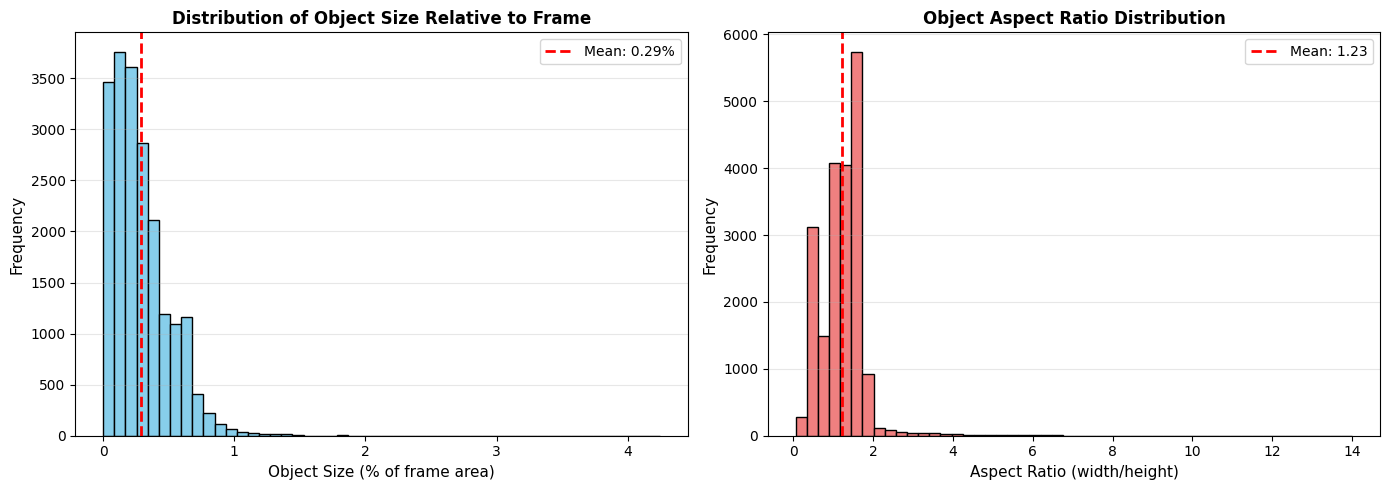

Mean size: 0.29%


In [5]:
analyzer.plot_size_analysis()
size_df = analyzer.compute_size_data()
print(f"Mean size: {size_df['relative_size_%'].mean():.2f}%")

### Insights

Thách thức lớn nhất khi làm việc với bộ dữ liệu này là mô hình phải có khả năng phát hiện các đối tượng **vừa cực kỳ nhỏ** (chiếm trung bình chỉ 0.29% diện tích khung hình) **vừa có hình dạng rất đa dạng** (bao gồm cả vật thể "cao", "vuông" và "rộng", thể hiện qua phân bố tỷ lệ khung hình với giá trị trung bình 1.23 nhưng trải rộng).

Đây là một bài toán **phát hiện vật thể nhỏ (small object detection)** điển hình, vốn rất khó vì thông tin chi tiết của vật thể dễ bị mất qua các lớp mạng và sự đa dạng về hình dạng đòi hỏi mô hình phải rất linh hoạt.

### Next Steps

1.  **Giải quyết vấn đề kích thước nhỏ:**
    * Sử dụng kiến trúc mạng có khả năng phát hiện đa tỷ lệ (multi-scale detection) như **FPN (Feature Pyramid Network)** để bắt các đặc trưng ở cả tầng nông (chi tiết) và tầng sâu (ngữ cảnh).
    * Tăng **độ phân giải hình ảnh đầu vào** (input resolution) cho mô hình, hoặc áp dụng kỹ thuật **"tiling"** (chia ảnh lớn thành các ảnh nhỏ hơn) để "phóng to" các vật thể nhỏ một cách hiệu quả.

2.  **Giải quyết vấn đề hình dạng đa dạng:**
    * **Không sử dụng anchor box mặc định.** Cần phải chạy thuật toán (như K-means clustering) trực tiếp trên kích thước và tỷ lệ khung hình (width/height) của các đối tượng trong bộ dữ liệu này để tạo ra một bộ **anchor box tùy chỉnh (custom anchors)**, đảm bảo chúng đại diện tốt cho cả 3 nhóm hình dạng chính (cao, vuông, rộng) phủ toàn bộ object lạ.

## 5. Visibility Analysis

📊 Computing visibility data...
✅ Computed visibility data: 14 videos
✅ Saved: object_visibility_analysis.png


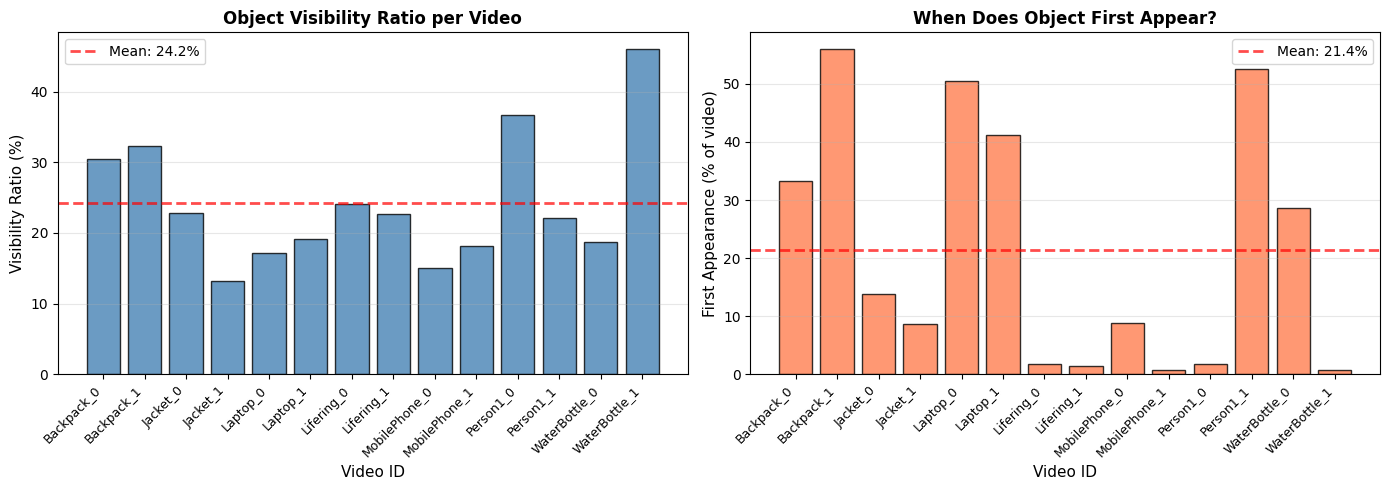

Mean visibility: 24.2%


In [6]:
analyzer.plot_visibility_analysis()
vis_df = analyzer.compute_visibility_data()
print(f"Mean visibility: {vis_df['visibility_ratio_%'].mean():.1f}%")

### Insights
Đây là một bộ dữ liệu **tracking (theo vết)** có hai vấn đề chính: **che khuất nghiêm trọng (severe occlusion)** và **vật thể xuất hiện muộn (late entry)**.

1.  **Che khuất (Chart 1):** Trung bình, một vật thể chỉ **hiển thị rõ 24.2%** thời lượng video. Điều này có nghĩa là trong ~76% thời gian còn lại, vật thể bị che khuất hoặc ra khỏi khung hình.
2.  **Xuất hiện muộn (Chart 2):** Trung bình, một vật thể **không xuất hiện cho đến khi 21.4%** thời lượng video đã trôi qua. Nhiều trường hợp (như Backpack_1, Laptop_0) vật thể chỉ xuất hiện sau mốc 50% video.

Mô hình AI phải có khả năng xử lý việc vật thể liên tục biến mất và xuất hiện trở lại, đồng thời phải "kiên nhẫn" không dự đoán nhầm khi vật thể chưa hề xuất hiện ở đầu video.

### Next Steps

1.  **Sử dụng thuật toán Video Tracking:** Không thể chỉ dựa vào phát hiện trên từng frame (frame-by-frame). Cần áp dụng các thuật toán tracking hoặc các mô hình Video Object Detection (VOD) có khả năng liên kết đối tượng qua thời gian (temporal consistency).
2.  **Tập trung vào Re-Identification (Re-ID):** Vì độ che khuất rất cao, tính năng then chốt là **Re-ID (tái nhận dạng)**. Mô hình cần một cơ chế "trí nhớ" để nhận diện lại đúng đối tượng khi nó tái xuất hiện sau khi bị che khuất.

## 6. Position Analysis

📊 Computing position data...
✅ Computed position data: 20216 bboxes
✅ Saved: object_position_analysis.png


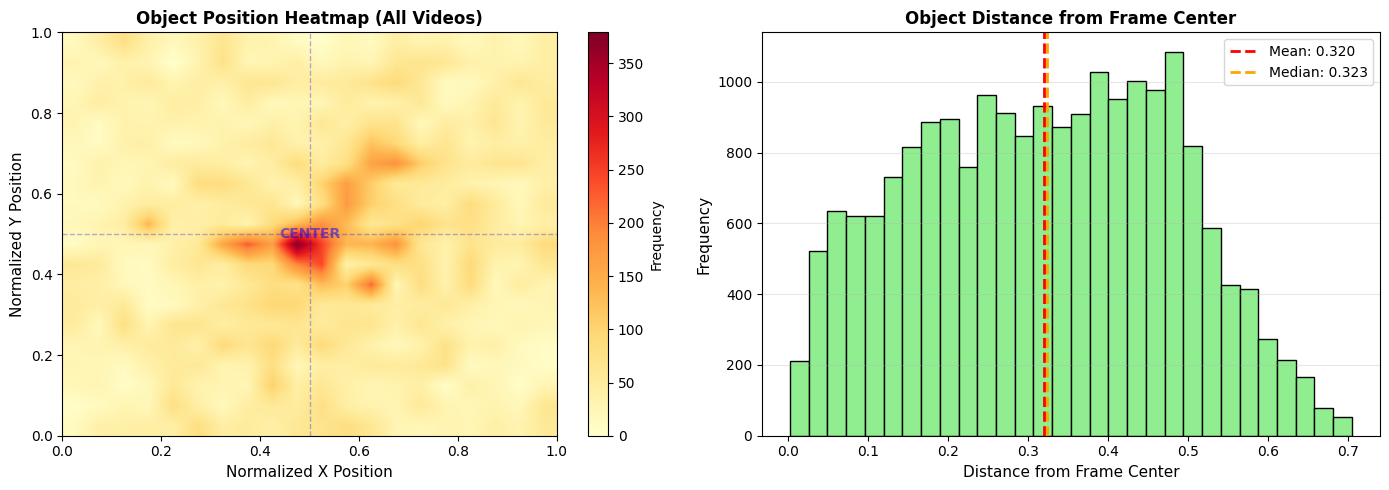

Mean distance from center: 0.320


In [7]:
analyzer.plot_position_analysis()
pos_df = analyzer.compute_position_data()
print(f"Mean distance from center: {pos_df['dist_from_center'].mean():.3f}")

### Insights
Bộ dữ liệu có một độ thiên vị trung tâm (central bias) rất mạnh.

Các vật thể gần như thường xuất hiện và di chuyển xung quanh khu vực giữa khung hình (như được thể hiện rõ trên heatmap). Các góc và vùng rìa của video chứa rất ít thông tin hữu ích và chủ yếu là bối cảnh (background) nhiễu.

## 7. Motion Analysis

📊 Computing motion data...
✅ Computed motion data: 20098 movements
✅ Saved: object_motion_analysis.png


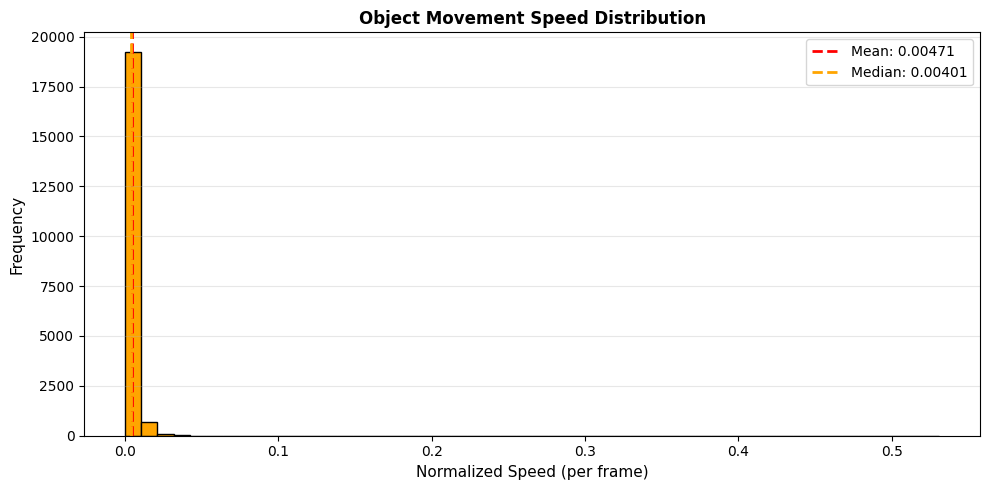

Mean speed: 0.00471


In [8]:
# === Cell 4: Motion Analysis ===
analyzer.plot_motion_analysis()
motion_df = analyzer.compute_motion_data()
print(f"Mean speed: {motion_df['speed'].mean():.5f}")

### Insights

Đây là một bộ dữ liệu **gần như tĩnh (static)**, với chuyển động của vật thể là **cực kỳ chậm hoặc không đáng kể**.

Toàn bộ phân bố tốc độ (Normalized Speed) ở sát mốc 0. Cả tốc độ trung bình (Mean: 0.00471) và trung vị (Median: 0.00401) đều rất nhỏ, điều này chứng minh rằng trong phần lớn thời gian, các vật thể gần như đứng yên, cho thấy rằng yếu tố chuyển động (motion blur, dự đoán quỹ đạo) không phải là một thách thức lớn trong bộ dữ liệu này.

## 8. Summary

In [9]:
# === Cell 5: Summary ===
analyzer.generate_summary_report()


📋 DATASET ANALYSIS SUMMARY REPORT

📹 Total Videos: 14
🎯 Total Frames with Object: 20106

📏 OBJECT SIZE STATISTICS:
   Mean relative size: 0.29%
   Median relative size: 0.22%
   Min relative size: 0.00%
   Max relative size: 4.24%
   Mean aspect ratio: 1.23

👁️  VISIBILITY STATISTICS:
   Mean visibility ratio: 24.20%
   Median visibility ratio: 22.38%
   Mean first appearance: 21.4% of video
   Mean appearance duration: 4382 frames
   Mean number of intervals: 8.4

📍 POSITION STATISTICS:
   Mean distance from center: 0.320
   Median distance from center: 0.323
   Most common zone: center

🏃 MOTION STATISTICS:
   Mean speed: 0.00471
   Median speed: 0.00401
   Max speed: 0.53091
   Mean displacement: 0.00492

✅ Analysis Complete! Check generated PNG files for visualizations.


### Insights

Đây là một bộ dữ liệu **tracking (theo vết) cực kỳ thách thức**. Thách thức lớn nhất không phải là tốc độ, mà là việc vật thể **liên tục bị che khuất và có kích thước siêu nhỏ**.

1.  **Mức độ che khuất (Occlusion) rất nghiêm trọng:**
    * Trung bình, một vật thể chỉ **hiển thị rõ ràng 24.2%** thời gian. Điều này có nghĩa là gần 76% thời gian vật thể bị che khuất hoặc nằm ngoài khung hình.
    * Một vật thể trung bình **biến mất và xuất hiện trở lại 8.4 lần** (intervals) trong suốt quá trình tracking. Điều này đặt ra yêu cầu rất cao cho khả năng **Re-Identification (tái nhận dạng)** của mô hình.

2.  **Vật thể xuất hiện muộn:**
    * Vật thể không có sẵn ở đầu video. Trung bình, chúng chỉ xuất hiện lần đầu tiên sau khi **21.4%** thời lượng video đã trôi qua. Điều này cho thấy mô hình cần phải làm việc tốt với từng object cụ thể được nhập vào input, hướng tiếp theo có thể sẽ là huấn luyện mô hình cách tạo dấu vân tay riêng biệt cho từng vật thể trong điều kiện khó khăn (như che khuất bởi cây, mưa phùn, sương mù,...) và vật thể thường chiếm kích thước nhỏ.